In [ ]:
# 1. Wczytanie bibliotek

import math
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as st

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf

from scipy.optimize import minimize

warnings.filterwarnings("ignore")

In [ ]:
# 1. Konfiguracja

TICKER = "NVDA"
START_DATE = "2015-01-01"
END_DATE = None        # None = do dziś
H = 22                 # okno zmienności (22 sesje - miesięczna zmienność )

In [ ]:
# 2. Dane – Yahoo Finance
df = yf.download(
    TICKER,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=False,
    progress=False
)

df = df.reset_index()
df = df.rename(columns={
    "Open": "Open",
    "High": "High",
    "Low": "Low",
    "Close": "Close",
    "Volume": "Volume",
    "Date": "Date"
})

print(f"Zakres danych: {df['Date'].min().date()} – {df['Date'].max().date()}")
print(f"Liczba obserwacji: {len(df)}")

Zakres danych: 2015-01-02 – 2025-12-18
Liczba obserwacji: 2758


Stopa zwrotu dana jest wzorem $r_t = \ln(C_t) - \ln(C_{t-1})$.


In [ ]:
# logarytmiczne stopy zwrotu
df["log_close"] = np.log(df["Close"])
df["r"] = df["log_close"].diff()
df = df.dropna().reset_index(drop=True)

Zmienność zrealizowana dana jest wzorem
$$
RV_t = \sum_{i=0}^{H-1} r_{t-i}^2.
$$

Bipower Variation dana jest wzorem
$$
BV_t = \frac{\pi}{2} \sum_{i=1}^{H-1} |r_{t-i}|\,|r_{t-i-1}|.
$$

Estymator MinRV dany jest wzorem
$$
MinRV_t =
\frac{\pi}{\pi - 2}
\sum_{i=1}^{H-1}
\min\!\left(|r_{t-i}|,\;|r_{t-i-1}|\right)^2.
$$

Estymator MedRV dany jest wzorem
$$
MedRV_t =
\frac{\pi}{6 - 4\sqrt{3} + \pi}
\sum_{i=1}^{H-2}
\operatorname{median}
\left(
|r_{t-i-1}|,\;
|r_{t-i}|,\;
|r_{t-i+1}|
\right)^2.
$$

In [ ]:
# 3. Zmienność zrealizowana – dzienne zwroty
r = df["r"].to_numpy()

# RV - realized variance - zmiennośc zrealizowana
df["RV"] = pd.Series(r**2).rolling(H).sum()

# BV (Bipower Variation)
absr = np.abs(r)
df["BV"] = (math.pi / 2) * pd.Series(absr).rolling(H).apply(
    lambda x: np.sum(x[1:] * x[:-1]), raw=True
)

# Estymatory odporne na skoki

# MinRV
def minrv_window(x):
    x = np.abs(x)
    return (math.pi / (math.pi - 2)) * np.sum(np.minimum(x[1:], x[:-1])**2)

# MedRV
def medrv_window(x):
    x = np.abs(x)
    m = [np.median([x[i-1], x[i], x[i+1]])**2 for i in range(1, len(x)-1)]
    return (math.pi / (6 - 4 * math.sqrt(3) + math.pi)) * np.sum(m)

df["MinRV"] = pd.Series(r).rolling(H).apply(minrv_window, raw=True)
df["MedRV"] = pd.Series(r).rolling(H).apply(medrv_window, raw=True)


Zmienność Parkinsona dana jest wzorem
$$
\sigma^2_{P,t}
=
\frac{1}{4\ln(2)}
\left[
\ln\!\left(\frac{H_t}{L_t}\right)
\right]^2.
$$

Zmienność Garmana--Klassa dana jest wzorem
$$
\sigma^2_{GK,t}
=
\frac{1}{2}
\left[
\ln\!\left(\frac{H_t}{L_t}\right)
\right]^2
-
\left(2\ln 2 - 1\right)
\left[
\ln\!\left(\frac{C_t}{O_t}\right)
\right]^2.
$$

Zmienność Rogersa--Satchella dana jest wzorem
$$
\sigma^2_{RS,t}
=
\ln\!\left(\frac{H_t}{O_t}\right)
\ln\!\left(\frac{H_t}{C_t}\right)
+
\ln\!\left(\frac{L_t}{O_t}\right)
\ln\!\left(\frac{L_t}{C_t}\right).
$$

Zmienność Yang--Zhanga dana jest wzorem
$$
\sigma^2_{YZ,t}
=
\ln^2\!\left(\frac{O_t}{C_{t-1}}\right)
+
k \ln^2\!\left(\frac{C_t}{O_t}\right)
+
(1-k)\sigma^2_{RS,t},
$$
gdzie
$$
k =
\frac{0.34}{1.34 + \frac{H+1}{H-1}}.
$$

In [ ]:
# 4. Estymatory OHLC

df["parkinson_d"] = (1 / (4 * np.log(2))) * (np.log(df["High"] / df["Low"])**2)

df["gk_d"] = (
    0.5 * (np.log(df["High"] / df["Low"])**2)
    - (2 * np.log(2) - 1) * (np.log(df["Close"] / df["Open"])**2)
)

df["rs_d"] = (
    np.log(df["High"] / df["Open"]) * np.log(df["High"] / df["Close"])
    + np.log(df["Low"] / df["Open"]) * np.log(df["Low"] / df["Close"])
)

k = 0.34 / (1.34 + (H + 1) / (H - 1))
df["overnight"] = np.log(df["Open"] / df["Close"].shift(1))
df["oc"] = np.log(df["Close"] / df["Open"])
df["yz_d"] = df["overnight"]**2 + k * df["oc"]**2 + (1 - k) * df["rs_d"]

for col in ["parkinson_d", "gk_d", "rs_d", "yz_d"]:
    df[col.replace("_d", "")] = df[col].rolling(H).sum()

df = df.dropna().reset_index(drop=True)


Proces stóp zwrotu opisany jest równaniem
$$
r_t = \mu + \varepsilon_t.
$$

Innowacje opisane są zależnością
$$
\varepsilon_t = \sqrt{h_t}\,z_t,
\quad z_t \sim \mathcal{N}(0,1).
$$

Wariancja warunkowa w modelu GARCH(1,1) dana jest wzorem
$$
h_t
=
\omega
+
\alpha \varepsilon_{t-1}^2
+
\beta h_{t-1}.
$$

In [ ]:
# 5. Model GARCH(1,1) - MLE

ret = df["r"] * 100
ret = ret - ret.mean()
eps = ret.to_numpy()
T = len(eps)

def garch11_negloglike(theta):
    omega, alpha, beta = theta
    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 0.999:
        return 1e10

    h = np.zeros(T)
    h[0] = omega / (1 - alpha - beta)

    for t in range(1, T):
        h[t] = omega + alpha * eps[t-1]**2 + beta * h[t-1]

    ll = -0.5 * (np.log(2 * np.pi) + np.log(h) + eps**2 / h)
    return -np.sum(ll)

res = minimize(garch11_negloglike, x0=[1, 0.05, 0.9], method="Nelder-Mead")
omega, alpha, beta = res.x

h_t = np.zeros(T)
h_t[0] = omega / (1 - alpha - beta)
for t in range(1, T):
    h_t[t] = omega + alpha * eps[t-1]**2 + beta * h_t[t-1]

std_resid = eps / np.sqrt(h_t)

print("\nGARCH(1,1) parametry:")
print(f"omega={omega:.4f}, alpha={alpha:.4f}, beta={beta:.4f}, alpha+beta={alpha+beta:.4f}")


GARCH(1,1) parametry:
omega=0.8737, alpha=0.1283, beta=0.7851, alpha+beta=0.9135


Reszty standaryzowane dane są wzorem
$$
z_t = \frac{\varepsilon_t}{\sqrt{h_t}}.
$$

In [ ]:
# 6. Diagnostyka reszt

print("\nDiagnostyka reszt:")

print("\nLjung-Box – reszty")
print(acorr_ljungbox(std_resid, lags=[10, 20], return_df=True))

print("\nLjung-Box – reszty^2")
print(acorr_ljungbox(std_resid**2, lags=[10, 20], return_df=True))

arch_test = het_arch(std_resid, nlags=10)
print(f"\nARCH LM(10): stat={arch_test[0]:.4f}, p={arch_test[1]:.4f}")

jb = st.jarque_bera(std_resid)
print(f"Jarque–Bera: JB={jb.statistic:.2f}, p={jb.pvalue:.2e}")



Diagnostyka reszt:

Ljung-Box – reszty
      lb_stat  lb_pvalue
10  10.078758   0.433611
20  17.726141   0.605443

Ljung-Box – reszty^2
     lb_stat  lb_pvalue
10  4.630129   0.914478
20  6.679183   0.997612

ARCH LM(10): stat=4.7591, p=0.9067
Jarque–Bera: JB=7530.68, p=0.00e+00


Regresja Mincera--Zarnowitza dana jest wzorem
$$
RV^{\text{future}}_t
=
a
+
b \cdot \widehat{RV}_t
+
u_t.
$$

Testowana hipoteza ma postać
$$
H_0:\quad a = 0 \quad \text{oraz} \quad b = 1.
$$

In [ ]:
# 7. Mincer–Zarnowowitz
h1 = omega + alpha * eps**2 + beta * h_t
ab = alpha + beta

def garch_forecast_H(H, h1):
    out = np.zeros_like(h1, dtype=float)
    for k in range(1, H + 1):
        out += omega * (1 - ab**k) / (1 - ab) + (ab**k) * h1
    return out

forecast_H = garch_forecast_H(H, h1)

rv_future = (
    pd.Series((df["r"] * 100)**2)
    .rolling(H)
    .sum()
    .shift(-H + 1)
    .to_numpy()
)

mask = (~np.isnan(rv_future)) & (~np.isnan(forecast_H))

mz = pd.DataFrame({
    "RV_future": rv_future[mask],
    "Forecast": forecast_H[mask]
})

X = sm.add_constant(mz["Forecast"])
mz_model = sm.OLS(mz["RV_future"], X).fit()

print("\nRegresja Mincera–Zarnowitza:")
print(mz_model.summary())

# Test H0: a=0, b=1
R = np.array([[1, 0],
              [0, 1]])
q = np.array([0, 1])

wald = mz_model.wald_test((R, q))

F_val = float(np.asarray(wald.fvalue).squeeze())
p_val = float(np.asarray(wald.pvalue).squeeze())

print(f"Wald H0: a=0, b=1 → F={F_val:.3f}, p={p_val:.2e}")


Regresja Mincera–Zarnowitza:
                            OLS Regression Results                            
Dep. Variable:              RV_future   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     403.4
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           9.13e-84
Time:                        10:52:25   Log-Likelihood:                -17974.
No. Observations:                2714   AIC:                         3.595e+04
Df Residuals:                    2712   BIC:                         3.596e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.3364 

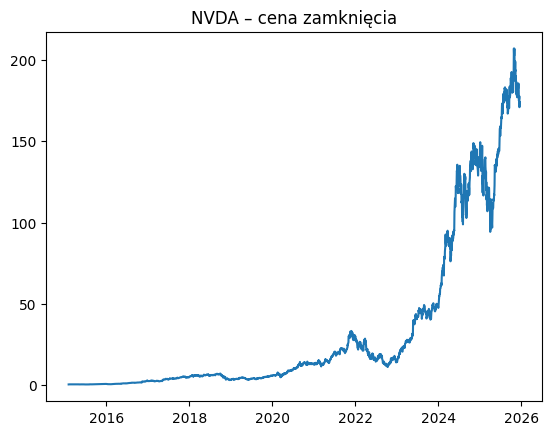

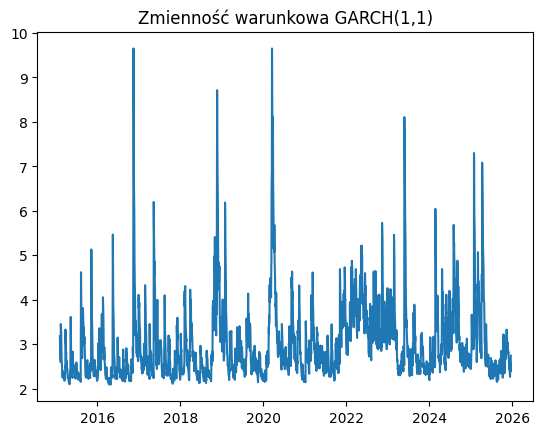

<Figure size 640x480 with 0 Axes>

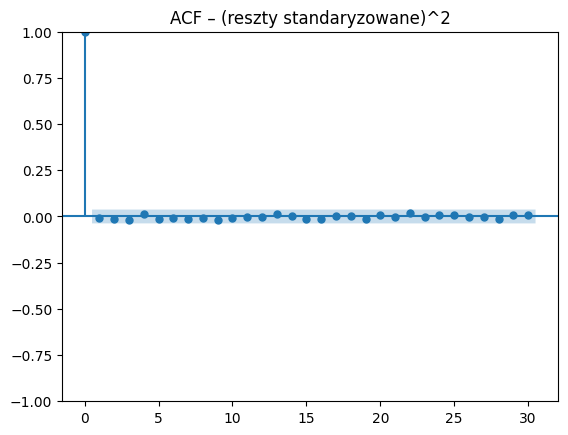

In [ ]:
# 8. Wykresy

plt.figure()
plt.plot(df["Date"], df["Close"])
plt.title("NVDA – cena zamknięcia")
plt.show()

plt.figure()
plt.plot(df["Date"], np.sqrt(h_t))
plt.title("Zmienność warunkowa GARCH(1,1)")
plt.show()

plt.figure()
plot_acf(std_resid**2, lags=30)
plt.title("ACF – (reszty standaryzowane)^2")
plt.show()